In [649]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from statsmodels import robust
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 3.0 Model Evaluation and Tuning

## 3.0 Get Data to be Modeled


I used David Ziganto's metrics and error functions to calculate the training error and validation error


In [90]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [405]:
def cross_validate_errors(modeldata, modeltarget, model):  
    """
    Function to take a model, folds and data/target and prints the train error and validation error for each fold
    """
    folds = KFold(n_splits=10, shuffle=True, random_state=15)
    train_e_list = []
    val_e_list = []
    for data_idx, val_idx in folds.split(modeldata,modeltarget):
        trainX = modeldata.iloc[data_idx]
        testX = modeldata.iloc[val_idx]
        trainy = modeltarget.iloc[data_idx]
        testy = modeltarget.iloc[val_idx]
        
        train_e, val_e = calc_metrics(trainX, trainy, testX, testy, model)
        train_e = (train_e)**-1
        val_e = (val_e)**-1
        
        train_e_list.append(train_e)
        val_e_list.append(val_e)
        
    terror = np.mean(train_e_list)
    verror = np.mean(val_e_list)
    return print(str(round(terror,6)) + ' Training Error, ' + str(round(verror,6)) + ' Valid error')

In [447]:
dataraw = pd.read_pickle('data/modeldata.pkl')
dataraw = dataraw.reset_index(drop=True)

In [448]:
dataraw.shape

(998, 10)

In [520]:
dataraw['logavgVORP'] = np.log(dataraw['avgVORP']+1e1)
dataraw['log10avgVORP'] = np.log10(dataraw['avgVORP']+1e1)

In [661]:
dataraw.head()

,draftnbr,Age,height,FG%,3P%,avgPTS,avgMP,avgTRB,avgAST,avgVORP,logavgVORP,log10avgVORP
0,1,19.0,6.833333,0.623,0.150,14.2,32.0,10.4,1.3,3.400000,2.595255,1.127105
1,2,19.0,6.583333,0.491,0.255,11.9,31.1,7.4,1.9,0.433333,2.345006,1.018423
2,3,19.0,6.416667,0.445,0.339,14.8,34.2,6.7,2.2,1.316667,2.426277,1.053719
3,4,21.0,6.333333,0.453,0.348,9.7,20.4,1.9,2.0,-0.312500,2.270836,0.986212
4,5,21.0,6.833333,0.525,0.500,9.8,18.7,7.3,1.0,-0.244444,2.277837,0.989252


## 3.1 Testing Lasso Lambda (alpha)
First using a basic model, we want to test lambdas (alphas in sklearn) so we run the basic model through cross validation using different alphas

In [653]:
modeldata = dataraw[['draftnbr','Age','avgTRB','avgAST','avgMP','avgPTS','FG%']]
modeltarget = dataraw[['logavgVORP']]

In [654]:
alpha = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
for alpha in alpha:
    lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
    print(alpha)
    cross_validate_errors(modeldata, modeltarget, lasso)
    print(lasso.fit(modeldata,modeltarget).coef_)

1e-07
140.485377 Training Error, 139.05435 Valid error
[-0.00303321 -0.00989958  0.01003583  0.02172156 -0.00028435 -0.00128428
  0.17104008]
1e-06
140.485366 Training Error, 139.054541 Valid error
[-0.00303379 -0.0098959   0.01003996  0.02171626 -0.00028527 -0.00128452
  0.17051541]
1e-05
140.484217 Training Error, 139.055487 Valid error
[-0.00303957 -0.00985906  0.01008117  0.02166326 -0.00029448 -0.00128688
  0.16526906]
0.0001
140.369587 Training Error, 138.967308 Valid error
[-0.00309738 -0.00949072  0.01049337  0.02113347 -0.00038664 -0.00131045
  0.11280557]
0.001
139.420325 Training Error, 138.605541 Valid error
[-0.0032458  -0.00828298  0.01093571  0.01907159 -0.00044393 -0.00129798
  0.        ]
0.01
135.144257 Training Error, 135.138043 Valid error
[-0.00354162 -0.00306973  0.00582747  0.00923338  0.         -0.          0.        ]
0.1
123.782407 Training Error, 125.265584 Valid error
[-0.00283128 -0.          0.          0.          0.          0.          0.        ]
1
10

In [655]:
m1 = make_pipeline(LinearRegression())
cross_validate_errors(modeldata, modeltarget, m1)

140.485377 Training Error, 139.054327 Valid error


In [656]:
m2 = make_pipeline(PolynomialFeatures(2), LinearRegression())
cross_validate_errors(modeldata, modeltarget, m2)
model1 = m2.fit(modeldata, modeltarget)
model1.steps[1][1].coef_

80.54274 Training Error, 77.042206 Valid error


array([[ -1.80431780e+10,  -4.14257755e-02,  -6.42740242e-02,
          1.18187747e-02,   1.77835614e-02,   1.19231794e-03,
         -2.68079437e-02,  -1.28105853e+00,   9.57692457e-05,
          2.06941995e-03,   1.21127395e-04,  -2.23747233e-03,
          8.66923336e-04,  -5.86165263e-04,  -4.58691626e-02,
          1.52093078e-03,  -2.65608808e-03,   4.99064009e-04,
         -3.36058297e-03,   3.67267038e-03,   3.96466732e-02,
         -3.30255674e-03,   2.86075298e-03,   2.49946407e-03,
         -5.92267889e-04,   6.04843471e-02,  -1.95591035e-02,
          4.02554120e-04,   5.83239730e-03,   1.03906653e-01,
          1.28887616e-03,  -3.18674682e-03,   2.99661762e-02,
          1.47333011e-03,  -2.15407966e-02,   1.28664585e-01]])

In [657]:
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
for alpha in alpha:
    lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
    m3 = make_pipeline(PolynomialFeatures(2), lasso)
    print(alpha)
    cross_validate_errors(modeldata, modeltarget, m3)
    modelcoef = m3.fit(modeldata,modeltarget)
    print(modelcoef.steps[1][1].coef_)

0.0001
152.75953 Training Error, 141.797656 Valid error
[  0.00000000e+00  -9.04749535e-03  -2.50968834e-02  -1.18611972e-02
   3.29900271e-05  -4.72571993e-03  -1.47627755e-02  -0.00000000e+00
   1.56412626e-04   4.01494295e-04  -1.53517394e-04  -9.84472589e-04
   1.01376619e-04  -1.06452780e-04  -1.16377774e-02  -2.92550916e-05
  -1.06611347e-04  -8.85382368e-04   7.92419655e-05   7.65077166e-04
   0.00000000e+00  -6.55815235e-05   8.39341278e-04   6.02395586e-04
   4.77207521e-05   1.12715841e-02  -4.00565520e-03   1.30292918e-03
   5.09730542e-04   5.84533310e-02  -9.48738024e-05  -2.75683008e-04
   9.94927097e-03   2.60921697e-04  -8.38511783e-03   0.00000000e+00]
0.001
151.201121 Training Error, 142.873719 Valid error
[  0.00000000e+00  -9.20200980e-03  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -0.00000000e+00   0.00000000e+00
   1.68132571e-04   1.97399549e-04  -2.21659220e-04  -9.46984367e-04
   8.70859137e-05  -7.67378777e-05  -2.72169367e-03  -2.403

In [658]:
h2 = make_pipeline(PolynomialFeatures(2), HuberRegressor())
cross_validate_errors(modeldata, modeltarget, h2)
h2.fit(modeldata, modeltarget).steps[1][1].coef_

26.406669 Training Error, 24.33735 Valid error


array([  4.64048728e-03,   3.49076131e-02,   5.01541593e-02,
         1.45660416e-02,   5.13164521e-03,   6.89372359e-02,
         3.47027258e-02,   2.19531142e-03,   2.72482531e-05,
        -1.79819571e-03,   2.33185476e-03,  -1.95373699e-03,
         5.06745059e-04,  -2.06910406e-03,   1.57470558e-02,
         1.79342842e-03,  -1.13311420e-02,   1.10567644e-03,
        -5.71796597e-03,   6.90882953e-03,   2.17497858e-02,
        -9.68050108e-03,   4.34672696e-03,   9.23005353e-03,
         1.39341367e-03,   6.20795627e-03,  -8.28615369e-03,
         1.90404300e-03,   1.32657052e-03,   2.34820467e-03,
        -5.80069406e-04,  -6.62825912e-05,   2.99255322e-02,
        -5.02848411e-03,   1.48704335e-02,   1.04009337e-03])

My Model Is Useless

## 3.2 Removing Outliers by Draft Nbr

Because of outliers on each draft position, there is no actual from draft number to carreer avgVORP

We still might be able to get some useful information by removing outliers by draft number, so there is a cleaner representation of each draft position.

In [555]:
medianvorpbypositionq1 = dataraw.groupby(['draftnbr'])[['logavgVORP']].quantile(q=0.25)
medianvorpbypositionq2 = dataraw.groupby(['draftnbr'])[['logavgVORP']].quantile(q=0.75)
iqrbydraft = pd.merge(medianvorpbypositionq1,medianvorpbypositionq2, how ='inner',left_index=True,right_index=True)
iqrbydraft = iqrbydraft.rename(columns={'logavgVORP_x': 'Q1','logavgVORP_y': 'Q3'})
iqrbydraft['IQR'] = iqrbydraft['Q3'] - iqrbydraft['Q1']
iqrbydraft['UB'] = (iqrbydraft['Q3'] + (.05 * iqrbydraft['IQR']))
iqrbydraft['LB'] = (iqrbydraft['Q1'] - (.05 * iqrbydraft['IQR']))
iqrbydraft

,Q1,Q3,IQR,UB,LB
draftnbr,,,,,
1,2.400921,2.556258,0.155337,2.564025,2.393154
2,2.318890,2.446786,0.127897,2.453181,2.312495
3,2.349415,2.500327,0.150912,2.507872,2.341869
4,2.324836,2.466561,0.141726,2.473648,2.317749
5,2.332387,2.494001,0.161614,2.502082,2.324306
6,2.277254,2.402657,0.125402,2.408927,2.270984
7,2.320308,2.399495,0.079188,2.403455,2.316348
8,2.305073,2.378671,0.073597,2.382350,2.301393
9,2.292088,2.471675,0.179587,2.480655,2.283109


In [543]:
Q1 = dataraw.logavgVORP.quantile(q=0.25)
Q3 = dataraw.logavgVORP.quantile(q=0.75)
iqr = Q3 - Q1
print(str(Q1-(1.5*iqr)) + ' ' + str(Q3+(1.5*iqr)))

2.134338342854445 2.54141745706349


In [556]:
dataiqr = pd.merge(dataraw,iqrbydraft[['UB','LB']],how ='inner',left_on='draftnbr',right_index=True)
conditions = [dataiqr['logavgVORP'] > dataiqr['UB'], dataiqr['logavgVORP']< dataiqr['LB']]
results = [True,True]
dataiqr['outlier'] = np.select(conditions,results,default=False)
dataiqr.head()

,draftnbr,Age,height,FG%,3P%,avgPTS,avgMP,avgTRB,avgAST,avgVORP,logavgVORP,log10avgVORP,UB,LB,outlier
0,1,19.0,6.833333,0.623,0.150,14.2,32.000000,10.4,1.3,3.400000,2.595255,1.127105,2.564025,2.393154,True
30,1,19.0,6.250000,0.529,0.462,17.5,27.500000,3.4,4.3,2.757143,2.546091,1.105753,2.564025,2.393154,False
59,1,20.0,6.333333,0.461,0.325,16.6,34.800000,4.3,6.5,2.675000,2.539632,1.102948,2.564025,2.393154,False
89,1,21.0,6.833333,0.618,0.300,18.8,29.975883,11.8,2.1,3.375000,2.593387,1.126294,2.564025,2.393154,True
117,1,20.0,6.250000,0.477,0.337,14.9,29.200000,4.5,4.7,1.155556,2.411938,1.047491,2.564025,2.393154,False


In [557]:
normalplayers = dataiqr[dataiqr['outlier']==False]
allstars = dataiqr[dataiqr['outlier']==True]

In [558]:
allstars.shape

(443, 15)

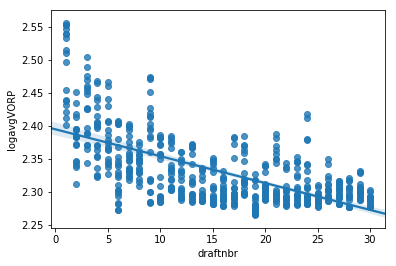

In [647]:
sns.regplot(x="draftnbr", y="logavgVORP", data=normalplayers);

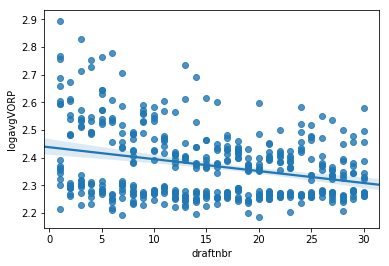

In [648]:
sns.regplot(x="draftnbr", y="logavgVORP", data=allstars);

In [560]:
modeldata2 = normalplayers[['draftnbr']]#,'Age','avgTRB','avgAST','avgMP','avgPTS','FG%']]
modeltarget2 = normalplayers[['logavgVORP']]

In [630]:
alpha = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
for alpha in alpha:
    lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
    pipe = make_pipeline(PolynomialFeatures(2),lasso)
    print(alpha)
    cross_validate_errors(modeldata2, modeltarget2, pipe)
    print(pipe.fit(modeldata2,modeltarget2).steps[1][1].coef_)

1e-07
698.520459 Training Error, 733.129111 Valid error
[ 0.         -0.01271371  0.00028078]
1e-06
698.520459 Training Error, 733.129334 Valid error
[ 0.         -0.01271348  0.00028078]
1e-05
698.520446 Training Error, 733.131552 Valid error
[ 0.         -0.01271126  0.00028071]
0.0001
698.519187 Training Error, 733.152551 Valid error
[ 0.         -0.01268896  0.00028003]
0.001
698.393438 Training Error, 733.244225 Valid error
[ 0.         -0.01246623  0.00027321]
0.01
686.343437 Training Error, 722.770513 Valid error
[ 0.         -0.01026808  0.00020589]
0.1
472.218944 Training Error, 496.849357 Valid error
[ 0.         -0.         -0.00010647]
1
469.22389 Training Error, 492.920116 Valid error
[  0.00000000e+00  -0.00000000e+00  -9.41954458e-05]
10.0
336.648289 Training Error, 344.718718 Valid error
[ 0. -0. -0.]


In [563]:
reg = LinearRegression()
cross_validate_errors(modeldata2, modeltarget2, reg)
print(reg.fit(modeldata2,modeltarget2).coef_)

565.339164 Training Error, 598.388176 Valid error
[[-0.00406374]]


## 3.4 Top 15 for Original and Outliers Removed

In [676]:
data15 = dataraw[dataraw['draftnbr']<16]
modeldata15 = data15[['draftnbr']]
modeltarget15 = data15[['logavgVORP']]

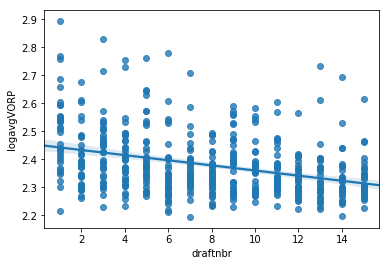

In [678]:
sns.regplot(x="draftnbr", y="logavgVORP", data=data15);

In [681]:
alpha = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
for alpha in alpha:
    lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
    pipe = make_pipeline(PolynomialFeatures(2),lasso)
    print(alpha)
    cross_validate_errors(modeldata15, modeltarget15, pipe)
    print(pipe.fit(modeldata15,modeltarget15).steps[1][1].coef_)

1e-07
92.29105 Training Error, 100.063392 Valid error
[ 0.         -0.01978842  0.00066318]
1e-06
92.29105 Training Error, 100.063458 Valid error
[ 0.         -0.01978746  0.00066313]
1e-05
92.291049 Training Error, 100.064122 Valid error
[ 0.         -0.01977789  0.00066256]
0.0001
92.290953 Training Error, 100.070651 Valid error
[ 0.         -0.01968214  0.00065689]
0.001
92.281295 Training Error, 100.125073 Valid error
[ 0.         -0.01872489  0.00060018]
0.01
91.384042 Training Error, 99.684966 Valid error
[  0.00000000e+00  -9.28030284e-03   4.06724526e-05]
0.1
89.0223 Training Error, 97.417776 Valid error
[ 0.         -0.         -0.00048522]
1
87.471159 Training Error, 95.861347 Valid error
[ 0.         -0.         -0.00030433]
10.0
79.989575 Training Error, 86.815154 Valid error
[ 0. -0. -0.]


In [682]:
data15adj = normalplayers[normalplayers['draftnbr']<16]
modeldata15adj = data15adj[['draftnbr']]
modeltarget15adj = data15adj[['logavgVORP']]

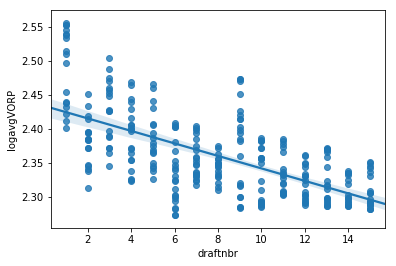

In [683]:
sns.regplot(x="draftnbr", y="logavgVORP", data=data15adj);

In [685]:
alpha = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
for alpha in alpha:
    lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
    pipe = make_pipeline(lasso)
    print(alpha)
    cross_validate_errors(modeldata15adj, modeltarget15adj, pipe)
    print(pipe.fit(modeldata15adj,modeltarget15adj).steps[0][1].coef_)

1e-07
469.396421 Training Error, 505.768915 Valid error
[-0.00920968]
1e-06
469.396421 Training Error, 505.769329 Valid error
[-0.00920963]
1e-05
469.39642 Training Error, 505.773475 Valid error
[-0.00920913]
0.0001
469.396299 Training Error, 505.814824 Valid error
[-0.00920412]
0.001
469.384141 Training Error, 506.217377 Valid error
[-0.00915401]
0.01
468.171501 Training Error, 509.110937 Valid error
[-0.00865293]
0.1
372.064925 Training Error, 418.834142 Valid error
[-0.00364211]
1
273.822243 Training Error, 298.568277 Valid error
[-0.]
10.0
273.822243 Training Error, 298.568277 Valid error
[-0.]
